## 神经网络怎么工作的

In [90]:
!python --version
%pip install ipywidgets
%pip install matplotlib
%pip install numpy
%pip install fastai

Python 3.10.9
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [91]:
from ipywidgets import interact
from fastai.basics import *

# 设置所有图形的默认 DPI（每英寸点数）为 90。
plt.rc('figure', dpi=90)
# 一个绘制函数的简单包装器，用于在交互式小部件中绘制函数。
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title) # 如果标题不是空的，就设置标题。

### 首先展示一个 一元二次方程

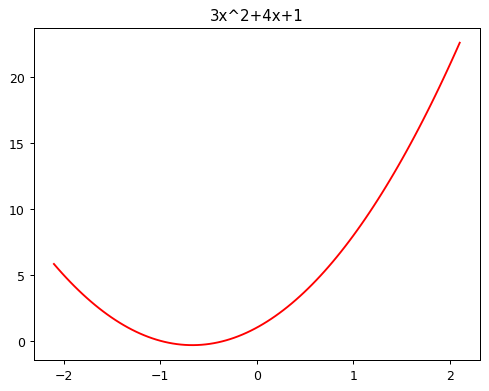

In [92]:
def f(x): return 3*x**2+ 4*x+ 1

plot_function(f, '3x^2+4x+1')

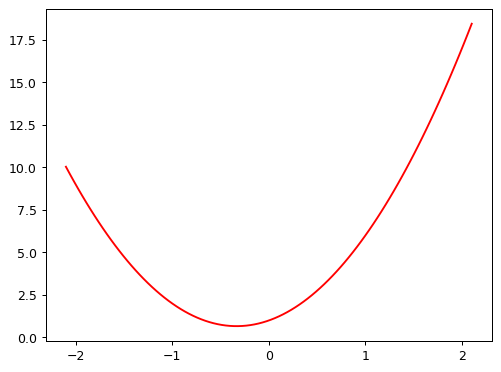

In [93]:
def quad(a, b, c, x): return a*x**2 + b*x + c
# 专门生成一个二次函数的函数。
def mk_quad(a,b,c): return partial(quad, a,b,c)
f2 = mk_quad(3,2,1)
plot_function(f2)

In [94]:
# 生成一些随机数据，也叫做噪声
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
# 对输入的x加入乘性噪声和加性噪声 模拟显示中的常见噪声，说明白了就是模拟显示数据的不确定性
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [95]:
"""
作用：设置 NumPy 的随机数种子为 42。
效果：确保每次运行时，np.random.normal 生成的随机数序列是固定的、可重复的。这对调试或实验重现非常有用。
影响：后续调用 noise 函数时，生成的噪声将是确定的。
"""
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)
print(x.shape, y.shape)

torch.Size([20, 1]) torch.Size([20, 1])


/tmp/ipykernel_1037/1462939656.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)


In [96]:
# 移动滑块，让图像越来越满足这个数据的分布，这就像是在训练模型，让模型逐渐拟合数据。
@interact(a=1.1, b=1.1, c=1.1)  #
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))



interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [97]:
# 如何衡量足够拟合曲线了呢？
# 一个方式是计算预测值和真实值之间的差异，然后求平均值。
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [ ]:
"""
    MSE 是 Mean Squared Error（均方误差）的缩写。它是一个用来衡量预测值和实际值之间差异的指标，广泛用于回归任务（比如预测房价、温度等连续值）。

    定义：
    MSE 计算的是预测值（preds）和实际值（acts）之间差值的平方的平均值。
    MSE 的作用是量化误差的大小，帮助我们评估模型预测的准确性：

    如果 MSE 很小，说明预测值和实际值很接近，模型表现好。
    如果 MSE 很大，说明误差大，模型需要改进。
"""
def mse(preds, acts):
    return ((preds - acts) ** 2).mean()
"""
用参数 params 定义的二次函数 f(x) 预测 x，然后和真实值 y 对比，算出的平均平方误差。
输出是一个损失值（loss），用来衡量预测值和真实值之间的差异。
告诉你这条抛物线拟合数据的“偏差程度”，值越小越好。
"""
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x), y)


print(x.shape,y.shape)
quad_mse([1.5, 1.5, 1.5])

torch.Size([20, 1]) torch.Size([20, 1])


tensor(5.2035, dtype=torch.float64)

In [112]:
abc = torch.tensor([1.5, 1.5, 1.5]).requires_grad_()

In [113]:
loss = quad_mse(abc)
loss

tensor(8.3700, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [107]:
loss.backward()  # 自动计算梯度


In [109]:


"""
    梯度下降是一种优化算法，用来找到一个函数的最小值。在我们的例子中，这个函数是 quad_mse，也就是预测值和真实值之间的均方误差。

    梯度下降的基本思想是：

    从一个随机的起始点开始（比如 abc = [1.5, 2.5, 1.5]）。
    计算函数在这个点的梯度（也就是函数变化最快的方向）。
    沿着梯度的反方向，移动一小步（比如 0.1 的步长）。
    重复这个过程，直到找到函数的最小值。
"""
"""
    梯度 输出会是一个tensor  里面的值是梯度
    他告诉我我们，如何增加abc的值，损失会下降对应的梯度值
    比如 但当前单元格输出是tensor([-xxx,  -xxx2  -xxx3])
    那么如果a+1  b+1  c+1  损失相应会下降-xxx,  -xxx2  -xxx3
"""
abc.grad

tensor([-6.1684, -4.6402, -1.4438])

In [110]:
with torch.no_grad():  # torch.no_grad()用来关闭梯度计算,如果不关闭梯度计算，那么每次计算都会记录梯度，会导致内存占用过多
    abc -= 0.1 * abc.grad
    loss = quad_mse(abc)
print(f'loss = {loss:.2f}')

loss = 4.29


In [ ]:
# 根据梯度 逐渐降低loss, 使得loss缩小
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad():
        abc -= (abc.grad * 0.1)
        abc.grad.zero_()
    print(f'step = {i};loss = {loss:.2f}')

step = 0;loss = 5.97
step = 1;loss = 5.29
step = 2;loss = 3.55
step = 3;loss = 2.69
step = 4;loss = 2.26


In [ ]:
abc

tensor([2.1617, 4.6988, 0.3504], requires_grad=True)

## 第二个部分

In [121]:
#计算一条直线输出，直线的斜率是m，截距是b。且所有的y值都是大于0的，小于0的会被截取掉，变成0
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y,0.)

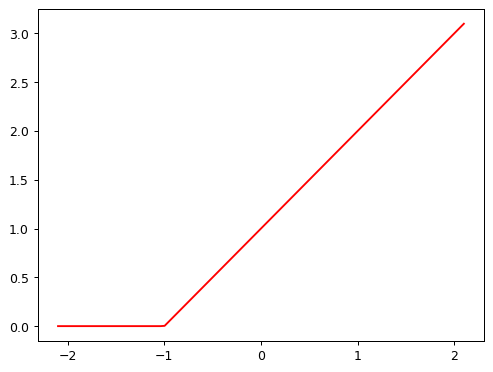

In [ ]:
# partial 函数用来创建一个新函数，这个新函数是 rectified_linear 的一个特例，其中 m=1，b=1。而x是一个变量，可以是任意值。
plot_function(partial(rectified_linear, 1, 1))

In [123]:
@interact(m=1.1, b=1.1)
def plot_rect(m, b):

    plot_function(partial(rectified_linear, m, b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.1, description='m', max=3.3000000000000003, min=-1.1), FloatSlider(v…